In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Print current working directory and its contents
print("Current working directory:", os.getcwd())
print("Contents of current directory:", os.listdir())

# Load the CSV file
df = pd.read_csv('color_labels.csv')

# Create a dictionary mapping filenames to color labels
color_map = dict(zip(df['filename'], df['color']))

# Define color categories
color_categories = sorted(df['color'].unique())

# Create a mapping of colors to integer labels
color_to_label = {color: i for i, color in enumerate(color_categories)}

def load_and_preprocess_image(filename):
    img_path = os.path.join('color_images', filename)
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img)
    return img_array / 255.0  # Normalize pixel values

# Create dataset
X = np.array([load_and_preprocess_image(filename) for filename in df['filename']])
y = np.array([color_to_label[color] for color in df['color']])

# Convert labels to categorical
y = tf.keras.utils.to_categorical(y, num_classes=len(color_categories))

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of validation data:", X_val.shape)


Current working directory: C:\Users\KIIT\Desktop\jujuju\Untitled Folder
Contents of current directory: ['.ipynb_checkpoints', 'color_images', 'color_labels.csv', 'Untitled.ipynb']
Shape of training data: (4, 32, 32, 3)
Shape of validation data: (2, 32, 32, 3)


In [9]:
!python -c "import tensorflow as tf; print(tf.__version__)"


2.18.0


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6 output neurons for 6 color categories
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: 1.7509 - val_accuracy: 0.0000e+00 - val_loss: 1.9956
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5000 - loss: 1.6006 - val_accuracy: 0.0000e+00 - val_loss: 2.2238
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5000 - loss: 1.4577 - val_accuracy: 0.0000e+00 - val_loss: 2.5703
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5000 - loss: 1.2867 - val_accuracy: 0.0000e+00 - val_loss: 3.0653
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5000 - loss: 1.1343 - val_accuracy: 0.0000e+00 - val_loss: 3.7110
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5000 - loss: 0.9860 - val_accuracy: 0.0000e+00 - val_loss: 4.4771
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.8271 - val_accuracy: 0.0000e+00 - val_loss: 5.3703
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.7009 - val_accu

In [15]:
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'\nValidation accuracy: {test_acc}')


1/1 - 0s - 45ms/step - accuracy: 0.0000e+00 - loss: 40.3159

Validation accuracy: 0.0


In [17]:
model.save('color_detection_model.h5')


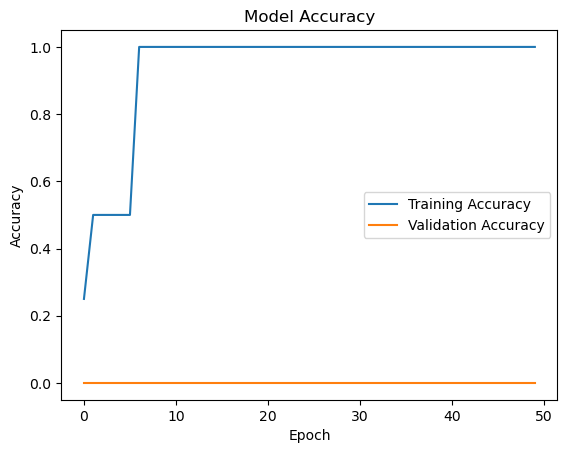

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [25]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_color(image_path):
    img = load_img(image_path, target_size=(32, 32))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    return color_categories[predicted_class[0]]

# Test the function
test_image_path = r"C:\Users\KIIT\Pictures\vehicle\creta.jpg"
predicted_color = predict_color(test_image_path)
print(f"Predicted color: {predicted_color}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted color: orange


In [39]:
def detect_color_with_confidence(image_bytes):
    img = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0
    prediction = model.predict(np.expand_dims(img, axis=0))[0]
    color_names = ['Red', 'Green', 'Blue', 'Yellow', 'Orange', 'Purple']
    return {color: float(conf) for color, conf in zip(color_names, prediction)}


In [35]:
import matplotlib.pyplot as plt  # Correct import

def plot_color_distribution(color_conf):
    plt.figure(figsize=(10, 5))
    plt.bar(color_conf.keys(), color_conf.values())
    plt.title('Color Distribution')
    plt.xlabel('Colors')
    plt.ylabel('Confidence')
    plt.ylim(0, 1)
    plt.show()


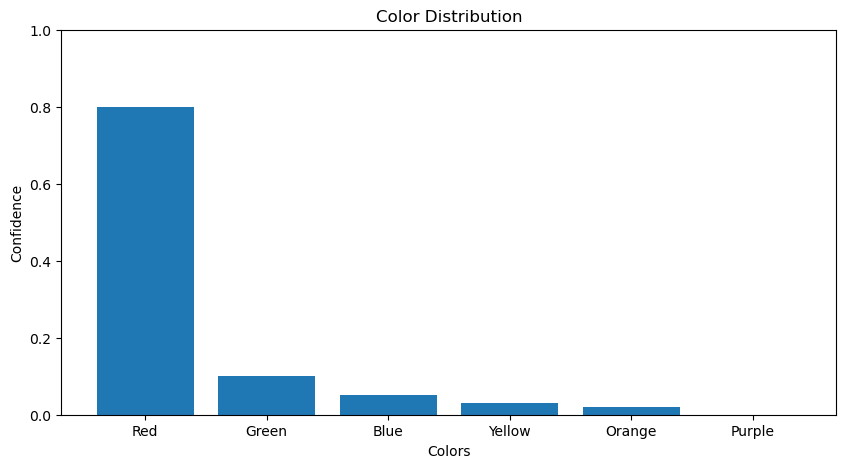

In [37]:
sample_color_conf = {
    'Red': 0.8,
    'Green': 0.1,
    'Blue': 0.05,
    'Yellow': 0.03,
    'Orange': 0.02,
    'Purple': 0.0
}

plot_color_distribution(sample_color_conf)
